![](figs/se_03.png)
# Workshop Instructions
***
- <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> Follow along by typing the code yourself - this helps with learning!
- <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> Code cells marked as "Exercise" are for you to complete
- <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> Look for hints if you get stuck
- <img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> Compare your solution with the provided answers
- <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> Don't worry if you make mistakes - debugging is part of learning!

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import utils
from pathlib import Path
import sys

helper_utils = Path.cwd().parent
sys.path.append(str(helper_utils))


checker = utils.core.ExerciseChecker("SE03")
quizzer = utils.core.QuizManager("SE03")

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 0.8.0


# 1. PyTorch workflow
***
The previous session we had a look at the basics of neural networks and how to train a single layer perceptron. In this session we will look at the PyTorch framework and how to use it to build and train neural networks.

Most deep learning projects follow a similar workflow. The following figure illustrates the typical workflow of a PyTorch project:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\pytorch_workflow.png" alt="PyTorch WorkFlow" align="center" style="width: 80%; height: auto; margin: 0 auto;">
</figure>

The workflow consists of the following steps:

| Step | Description |
|------|----------|
| Obtain Data | Collect and preprocess the data for training and testing |
| Prepare Data | Setup data in PyTorch format |
| Pre-process Data | Normalize and augment the data. This may involve data cleaning, normalization, and splitting the data into training, validation, and test sets. |
| Activation Function | Choose an activation function for the model. This may involve selecting a suitable activation function for the model, such as ReLU, sigmoid, or tanh. |
| Model | Define the model architecture. |
| Choose optimiser | Select an optimiser for the model. |
| Choose loss function | Select a loss function for the model. |
| Create training loop | Define the training steps, including forward pass, backward pass, and parameter updates. |
| Fit model | Train the model using the training data. |
| Evaluate model | Evaluate the model using the validation and test data to make predictions |
| Improve model | Fine-tune the model by adjusting hyperparameters, adding regularization, or modifying the architecture. |
| Save or deploy model | Save the trained model for future use or deploy it in a production environment. |

## Step 1: Obtain Data
***
In this notebook we are going to be using the [ARKOMA dataset](https://www.sciencedirect.com/science/article/pii/S2352340923007989). The dataset is intended to be used as a benchmark for the creation of Neural Networks to perform inverse kinematics for robotic arms using a NAO robot. The dataset contains data for two different robotic arms: the left arm and the right arm. The data is generated using a physics engine that simulates the movement of the robotic arms in a 3D environment. The dataset contain 10,000 input-output data pairs for both arms. The input data is the end-effector position of the robotic arm, and the output data is the joint angles of the robotic arm. 

The input parameters are:
| Notation | Description |
|------|----------|
| $ P_{x} $ | The end-effector position with respect to the torso's x-axis |
| $ P_{y} $ | The end-effector position with respect to the torso's y-axis |
| $ P_{z} $ | The end-effector position with respect to the torso's z-axis |
| $ R_{x} $ | The end-effector orientation relative to the torso's x-axis |
| $ R_{y} $ | The end-effector orientation relative to the torso's y-axis |
| $ R_{z} $ | The end-effector orientation relative to the torso's z-axis |

The output parameters are:

| Notation | Left Arm Joint | Left Arm Range(rad) | Right Arm Joint | Right Arm Range(rad) |
|----------|----------------|--------------------|-----------------|--------------------|
| $ \theta_{1} $ | LShoulder Pitch | [-2.0857, 2.0857] | RShoulder Pitch | [-2.0857, 2.0857] |
| $ \theta_{2} $ | LShoulder Roll | [-0.3142, 1.3265] | RShoulder Roll | [-1.3265, 0.3142] |
| $ \theta_{3} $ | LElbow Yaw | [-2.0857, 2.0857] | RElbow Yaw | [-2.0857, 2.0857] |
| $ \theta_{4} $ | LElbow Roll | [-1.5446, 0.0349] | RElbow Roll | [-0.0349, 1.5446] |
| $ \theta_{5} $ | LWrist Yaw | [-1.8238, 1.8238] | RWrist Yaw | [-1.8238, 1.8238]  |

In this notebook, we are going to focus on the right arm. The data is stored in CSV format. To load the data, we will use the `pandas` library. 

In [2]:
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('ARKOMA',
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=True)

dataset_path = dataset_path / 'Dataset on NAO Robot Arms'

Downloading:
ARKOMA: The Dataset to Build Neural Networks-Based Inverse Kinematics for NAO Robot Arms
> Authors: Arif Nugroho, Eko Mulyanto Yuniarno, Mauridhi Hery Purnomo
> Year: 2020
> Website: https://www.sciencedirect.com/science/article/pii/S2352340923007989



Extracting Dataset on NAO Robot Arms.zip: 100%|██████████| 15/15 [00:00<00:00, 1071.80it/s]



In [3]:
# Set the path to the datasets (already provided above)
right_arm_path = dataset_path / 'Right Arm Dataset'

# Create file paths using a dictionary comprehension and format strings
file_parts = ['Train', 'Val', 'Test']
dataset_files = {
    part: {
        'features': right_arm_path / f'R{part}_x.csv',
        'targets': right_arm_path / f'R{part}_y.csv'
    } for part in file_parts
}

# Unpack into individual variables for compatibility with existing code
feats_train = dataset_files['Train']['features']
targets_train = dataset_files['Train']['targets']
feats_val = dataset_files['Val']['features']
targets_val = dataset_files['Val']['targets']
feats_test = dataset_files['Test']['features']
targets_test = dataset_files['Test']['targets']


## Step 2 and 3: Prepare and Pre-process Data
***
The next step is to pre-process the data. This involves normalizing the data and splitting it into training, validation, and test sets.

### Training, Validation, and Test Sets
***
One of the crucial steps in machine learning is to split the data into training, validation, and test sets. Each of these sets serves a specific purpose in the model development process:

| Dataset | Purpose | Typical Split | Usage | Analogy |
|---------|---------|---------------|--------|----------|
| Training Set | Used to train the model by adjusting weights and biases through backpropagation | 60-80% | Every training iteration | Like studying materials to learn a subject |
| Validation Set | Used to tune hyperparameters and monitor model performance during training to prevent overfitting | 10-20% | During model development | Like practice exams to gauge learning progress |
| Test Set | Used only once for final model evaluation; never used for training or tuning | 10-20% | Once, after training | Like a final exam with new, unseen questions |

The ARKOMA dataset has already been split into these three sets for us, which simplifies our workflow.

> **Note**: The test set is our generalisation benchmark. It is important to keep the test set separate from the training and validation sets to ensure that the model's performance is evaluated on unseen data. This helps us understand how well the model will perform in real-world scenarios. 

In [4]:
# Load the datasets
# Training set
X_train = pd.read_csv(feats_train)
y_train = pd.read_csv(targets_train)
# Test set
X_test = pd.read_csv(feats_test)
y_test = pd.read_csv(targets_test)
# Validation set
X_val = pd.read_csv(feats_val)
y_val = pd.read_csv(targets_val)

print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape} | y_val shape: {y_val.shape}")


X_train shape: (6000, 6) | y_train shape: (6000, 5)
X_test shape: (2000, 6) | y_test shape: (2000, 5)
X_val shape: (2000, 6) | y_val shape: (2000, 5)


In [5]:
X_train.head()

,Px,Py,Pz,Rx,Ry,Rz
0,116.12,-180.97,198.59,-10.39,-41.23,5.04
1,83.41,-228.19,-25.54,24.58,52.19,-43.12
2,45.81,-187.38,285.07,2.08,-81.96,-9.99
3,112.87,-146.16,-74.21,-19.96,56.73,13.66
4,175.85,-162.01,41.35,-21.91,5.63,10.07


In [6]:
y_train.head()

,joint1,joint2,joint3,joint4,joint5
0,-0.98727,-1.03049,-0.29515,1.19638,0.01696
1,0.49338,-0.92155,-1.00017,0.70232,1.33316
2,-1.32138,-0.60855,0.25970,0.48005,-0.29894
3,0.85806,-0.32185,-0.41366,0.38794,-0.00819
4,0.46961,-0.66923,0.44363,0.88413,-0.74223


### Normalisation
***
Normalisation is a crucial step in the pre-processing of data for machine learning models. It involves scaling the input features to a similar range, which helps improve the convergence speed and performance of the model. In this notebook, we will use Min-Max normalization to scale the input features to a range of [0, 1]. The formula for Min-Max normalization is as follows:
$$ X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

Where:
- $ X_{norm} $ is the normalized value.
- $ X$ is the original value.
- $ X_{min} $ is the minimum value of the feature.
- $ X_{max} $ is the maximum value of the feature.

The normalisation parameters will be computed from the training set and then applied to the validation and test sets. This helps to prevent data leakage and ensures that the model is evaluated on unseen data. 

***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 1**: Normalisation using Min-Max scaling

```python
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training
X_train_scaled = scaler.transform(X_train)

# Inverse transform the scaled data to get the original values
X_train_original = scaler.inverse_transform(X_train_scaled)
```

In [7]:
# Exercise 1: Data Loading and Preprocessing 🎯

# Create PyTorch tensors from the training, validation, and test data
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)  
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create MinMaxScalers for feature and target normalization
x_scaler = MinMaxScaler() # Your code here
y_scaler = MinMaxScaler() # Your code here

# Fit the scalers on training data and transform all datasets
x_scaler = x_scaler.fit(X_train_tensor) # Your code here
y_scaler = y_scaler.fit(y_train_tensor) # Your code here


# Fit the scalers on training data and transform all datasets
X_train_scaled = torch.tensor(x_scaler.transform(X_train_tensor), dtype=torch.float32)
X_val_scaled = torch.tensor(x_scaler.transform(X_val_tensor), dtype=torch.float32)
X_test_scaled = torch.tensor(x_scaler.transform(X_test_tensor), dtype=torch.float32)

y_train_scaled = torch.tensor(y_scaler.transform(y_train_tensor), dtype=torch.float32)
y_val_scaled = torch.tensor(y_scaler.transform(y_val_tensor), dtype=torch.float32)
y_test_scaled = torch.tensor(y_scaler.transform(y_test_tensor), dtype=torch.float32)

# Check the normalized data range
print(f"X_train normalized range: [{X_train_scaled.min().item():.4f}, {X_train_scaled.max().item():.4f}]")
print(f"y_train normalized range: [{y_train_scaled.min().item():.4f}, {y_train_scaled.max().item():.4f}]")

# ✅ Check your answer
answer = {
    'X_train_tensor': X_train_tensor,
    'y_train_tensor': y_train_tensor,
    'X_train_scaled': X_train_scaled,
    'y_train_scaled': y_train_scaled,
    'scale_range_min': X_train_scaled.min().item(),
    'scale_range_max': X_train_scaled.max().item(),
}
checker.check_exercise(1, answer)


X_train normalized range: [0.0000, 1.0000]
y_train normalized range: [0.0000, 1.0000]
--------------------------------------------------------------------------------
✅ X_train_tensor is correct!
✅ y_train_tensor is correct!
✅ X_train_scaled is correct!
✅ y_train_scaled is correct!
✅ scale_range_min is correct!
✅ scale_range_max is correct!

🎉 Excellent! All parts are correct!


## Step 4: Activation Function
***
The next step is to choose an activation function for the model. The activation function introduces non-linearity to the model, allowing it to learn complex relationships in the data. The following table lists some common activation functions used in neural networks, along with their characteristics and best use cases:

| Function | Formula | Range | Characteristics | Best Used For |
|----------|---------|-------|-----------------|---------------|
| ReLU | $f(x) = \max(0, x)$ | $[0, \infty)$ | Linear for positive values, zero for negative | Hidden layers in most networks |
| Sigmoid | $f(x) = \frac{1}{1+e^{-x}}$ | $(0, 1)$ | S-shaped curve, saturates at extremes | Binary classification, gates in LSTMs |
| Tanh | $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | $(-1, 1)$ | S-shaped curve, zero-centered | Hidden layers when output normalization is needed |
| Leaky ReLU | $f(x) = \max(\alpha x, x)$ | $(-\infty, \infty)$ | Small slope for negative values | Preventing "dead neurons" problem |
| Softmax | $f(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$ | $(0, 1)$ | Converts logits to probabilities | Multi-class classification output layer |

The choice of activation function depends on the specific problem and the architecture of the neural network. 

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - ReLU is the most commonly used activation function in hidden layers of deep networks due to its simplicity and effectiveness.
> - The activation function for the output layer depends on the type of problem being solved (e.g., regression, binary classification, multi-class classification).
***
> <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> **Common Mistakes to Avoid**: 
> - Mixing activation functions in the same layer (e.g., using ReLU and sigmoid together) can lead to unexpected behavior.
> - Using activation functions that saturate (like sigmoid) in hidden layers can lead to vanishing gradients, making training difficult.
> - Forgetting to apply the activation function to the output layer can lead to incorrect predictions (e.g., not using softmax for multi-class classification).
> - Not considering the range of the output when choosing the activation function (e.g., using sigmoid for regression tasks).

In [ ]:
print("\n🧠 Quiz 1: Choosing the right activation function")
quizzer.run_quiz(1)

print("\n🧠 Quiz 2: Combining activation functions")
quizzer.run_quiz(2)

--------------------------------------------------------------------------------
📋 Activation Functions Quiz
--------------------------------------------------------------------------------
For a regression problem like predicting the robot arm joint angles, which activation function would be most appropriate for the output layer?

A. Sigmoid - to constrain all outputs between 0 and 1
B. ReLU - to ensure no negative values in the output
C. Linear (no activation) - to allow any numeric output value
D. Softmax - to convert outputs into probability distributions
E. Tanh - to constrain all outputs between -1 and 1


❌ Incorrect. The correct answer is C.

📚 Explanation:
For regression problems, where we need to predict continuous values like joint angles, the linear activation (or no activation) is most appropriate for the output layer. This is because:

1. Regression outputs need the full range of possible values, not constrained to intervals like [0,1] (sigmoid) or [-1,1] (tanh).
2. Joint


## Step 5: Model
***
The next step is to define the model architecture. In order to create a Neural Network we need to stack multiple neurons together. This is known as a **layer**. A layer is a collection of neurons that work together to process the input data. A simple ANN is formed by three types of layers:
   - **Input Layer**: Receives the input data.
   - **Hidden Layers**: Intermediate layers that process the data.
   - **Output Layer**: Produces the final output.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\layers.png" alt="ANN layers" align="center" style="width: 20%; height: auto; margin: 0 auto;">
</figure>

The following table summarises the different types of layers available in PyTorch:

| Layer Type | Class | Description | Common Uses |
|------------|-------|-------------|------------|
| Fully Connected | `torch.nn.Linear(in_features, out_features)` | Standard dense layer | Classification, regression |
| Convolutional | `torch.nn.Conv2d(in_channels, out_channels, kernel_size)` | Spatial feature extraction | Image processing |
| Recurrent | `torch.nn.RNN(input_size, hidden_size)` | Sequential data processing | Time series, text |
| LSTM | `torch.nn.LSTM(input_size, hidden_size)` | Long-term dependencies | Complex sequences |
| Embedding | `torch.nn.Embedding(num_embeddings, embedding_dim)` | Word vector representations | NLP tasks |
| BatchNorm | `torch.nn.BatchNorm2d(num_features)` | Normalizes layer inputs | Training stability |
| Dropout | `torch.nn.Dropout(p=0.5)` | Randomly zeros elements | Regularization |

The choice of layer type depends on the specific problem and the architecture of the neural network. For example, convolutional layers are commonly used in image processing tasks, while recurrent layers are used for sequential data processing.

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - Start with a simple architecture and gradually increase complexity as needed.
> - The number of neurons in each layer can be adjusted based on the complexity of the problem.
> - Use activation functions after each layer to introduce non-linearity.
> - Experiment with different layer types and configurations to find the best architecture for your problem.





In [ ]:
# Quiz 3: Network Width
print("\n🧠 Quiz 3: Understanding Network Width for Inverse Kinematics")
quizzer.run_quiz(3)

# Quiz 4: Network Depth
print("\n🧠 Quiz 4: Understanding Network Depth for Inverse Kinematics")
quizzer.run_quiz(4)

# Quiz 5: Regularization Techniques
print("\n🧠 Quiz 5: Regularization Techniques for Kinematics Models")
quizzer.run_quiz(5)

Answering these quizzes will help you understand key concepts about neural network architecture
specifically for the robot arm inverse kinematics regression problem.


🧠 Quiz 3: Understanding Network Width for Inverse Kinematics
--------------------------------------------------------------------------------
📋 Neural Network Width Quiz
--------------------------------------------------------------------------------
For the robot arm inverse kinematics regression problem, which statement about network width (number of neurons in hidden layers) is most accurate?

A. A single neuron in each hidden layer is sufficient since this is a simple regression task
B. The number of neurons should exactly match the number of input features (6)
C. The hidden layers should have more neurons than inputs to capture complex spatial relationships
D. The hidden layers should have fewer neurons than the output to prevent overfitting
E. The width of the network doesn't impact performance, only the depth matt

### Initialising Weights and Biases
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Initialising weights and biases is the process of assigning initial values to these parameters before training a neural network.

The importance of initialising weights and biases lies in the fact that they can significantly affect the convergence speed and performance of the neural network. Proper initialisation can help prevent issues such as vanishing or exploding gradients, which can hinder the training process.

| Initialisation Method | Formula | PyTorch Code | Description |
|-----------------------|----------|--------------|-------------|
| Xavier/Glorot Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}})$ | `torch.nn.init.xavier_uniform_(tensor)` | Suitable for sigmoid and tanh activations. |
| He Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Kaiming Normal Initialisation | $W \sim \mathcal{N}(0, \sqrt{\frac{2}{n_{in}}})$ | `torch.nn.init.kaiming_normal_(tensor)` | Suitable for ReLU activations. |
| Kaiming Uniform Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Zero Initialisation | $W = 0$ | `torch.nn.init.zeros_(tensor)` | All weights are set to zero. Not recommended. |
| Random Initialisation | $W \sim \mathcal{U}(-1, 1)$ | `torch.nn.init.uniform_(tensor)` | Weights are randomly initialised between -1 and 1. |

In [20]:
# Exercise 3: Model Creation 🎯
# In this exercise, you will:
# 1. Create a neural network model using PyTorch
# 2. Define layers with appropriate activation functions
# 3. Implement a forward method

class RobotArmNetwork(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """Initialize a neural network for robotic arm inverse kinematics
        
        Args:
            input_size: Number of input features
            hidden_size: Number of neurons in the hidden layer
            output_size: Number of output features
        """
        # Initialize the parent class
        super().__init__()  # Your code here
        
        # Define the layers of your neural network
        self.fc1 = torch.nn.Linear(input_size, hidden_size)  # Your code here
        self.hidden_activation = torch.nn.ReLU()  # Your code here
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size // 2)  # Your code here
        self.fc3 = torch.nn.Linear(hidden_size // 2, output_size)  # Your code here
        
    def forward(self, x):
        """Forward pass through the network"""
        # Process input through first fully connected layer and activation function
        x = self.hidden_activation(self.fc1(x))  # Your code here
        
        # Process through second fully connected layer and activation function
        x = self.hidden_activation(self.fc2(x))  # Your code here
        
        # Process through output layer (no activation - we want raw values for regression)
        x = self.fc3(x)  # Your code here
        
        return x

# Initialize your model with appropriate dimensions
# 6 input features, 64 hidden neurons, 5 output features
model = RobotArmNetwork(input_size=6, hidden_size=64, output_size=5)  # Your code here

# Print your model architecture to verify it's correct
print(model)

# ✅ Check your answer
answer = {
    'model': model,
    'input_layer_size': model.fc1.in_features,
    'hidden_layer_size': model.fc1.out_features,
    'output_layer_size': model.fc3.out_features,
    'activation_type': type(model.hidden_activation)
}
checker.check_exercise(2, answer)

RobotArmNetwork(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (hidden_activation): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
)
--------------------------------------------------------------------------------
✅ model is correct!
✅ input_layer_size is correct!
✅ hidden_layer_size is correct!
✅ output_layer_size is correct!
❌ Error checking activation_type: unsupported operand type(s) for -: 'type' and 'bool'
💡 Hint: Initialize the parent class with super().__init__()


### Step 6: Choose Optimiser
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Optimisers are algorithms used to update the model parameters during training to minimise the loss function.

The next step is to choose an optimiser for the model.



The optimiser algorithm is used to update the model parameters during training. Most optimizers use a version of gradient descent to update the model parameters. The goal of the optimiser is to minimize the loss function by adjusting the weights and biases of the model. The most commonly used optimizers include:

- **Stochastic Gradient Descent (SGD):** A simple and widely used optimizer that updates the model parameters using the gradients of the loss function.
- **Adam:** An adaptive learning rate optimizer that combines the benefits of both SGD and RMSProp. It is widely used in deep learning applications due to its efficiency and effectiveness.
- **RMSProp:** An adaptive learning rate optimizer that adjusts the learning rate based on the average of recent gradients. It is particularly useful for training deep neural networks.
- **Adagrad:** An adaptive learning rate optimizer that adjusts the learning rate based on the historical gradients. It is particularly useful for sparse data.

The Adam optimiser is a popular choice for training deep learning models due to its efficiency and effectiveness. It combines the benefits of both SGD and RMSProp, making it suitable for a wide range of tasks.

### Learning Rate
***
The learning rate is a hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function. A small learning rate may lead to slow convergence, while a large learning rate may cause the model to diverge. It is important to choose an appropriate learning rate for the optimizer to work effectively

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs\learning_rate.png" alt="Gradient Descent" align="center" style="width: 50%; height: auto; margin: 0 auto;">
</figure>



In [13]:
optim = torch.optim.Adam(params=model_v1.parameters(),
                         lr=1e-2)
criterion = torch.nn.MSELoss()

model_v1.criterion = criterion
model_v1.optim = optim

In [14]:
# Exercise 4: Optimizer and Loss Function Selection 🎯
# In this exercise, you will:
# 1. Select an appropriate optimizer for your model
# 2. Choose a suitable loss function
# 3. Set the learning rate

# Create an Adam optimizer for your model
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001) # Your code here

# Create a Mean Squared Error loss function
loss_function = torch.nn.MSELoss() # Your code here

# Store the optimizer and loss function in the model for easy access
model.optimizer = optimizer
model.loss_function = loss_function

# Print the optimizer and loss function configuration
print(f"Optimizer: {type(model.optimizer).__name__}")
print(f"Learning rate: {model.optimizer.param_groups[0]['lr']}")
print(f"Loss function: {type(model.loss_function).__name__}")

# ✅ Check your answer
answer = {
    'optimizer_type': type(optimizer),
    'learning_rate': optimizer.param_groups[0]['lr'],
    'loss_function_type': type(loss_function)
}
checker.check_exercise(4, answer)

Optimizer: Adam
Learning rate: 0.001
Loss function: MSELoss
--------------------------------------------------------------------------------
❌ Missing train_losses
💡 Hint: Call model.train() to put the model in training mode
❌ Missing val_losses
❌ Missing loss_trend
❌ Missing overfit_check


### Step 7: Choose Loss Function
The next step is to choose a loss function for the model. In this case, we are going to use Mean Squared Error (MSE) loss function. The MSE loss function is commonly used for regression tasks and measures the average squared difference between the predicted and actual values. The formula for MSE is as follows:
$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2} $$

Where:
- $ n $ is the number of samples in the dataset.
- $ y_{i} $ is the actual value.
- $ \hat{y}_{i} $ is the predicted value.
- $ MSE $ is the mean squared error.

In PyTorch, the optimiser takes the model parameters as input and the learning rate as a hyperparameter.

The loss is also a PyTorch module that takes the model output and the target output as input. The loss function computes the loss value, which is then used to update the model parameters during training.

### Step 8: Create Training Loop
The next step is to create the training loop. The training loop consists of the following steps:

- Forward pass: The input data is passed through the model, and the output is computed.
- Compute loss: The loss is computed using the predicted output and the target output.
- Backward pass: The gradients of the loss function with respect to the model parameters are computed using backpropagation.
- Update parameters: The model parameters are updated using the computed gradients and the optimiser.
- Monitor performance: The training and validation loss is monitored during training to prevent overfitting.



> **Note**: The output of the layer in this case returns a tensor and `grad_fn` which is a reference to the function that created the tensor. This is used by PyTorch to keep track of the operations that have been performed on the tensor. This is important for the training process as it allows PyTorch to compute the gradients of the loss function with respect to the model parameters.

In [15]:
def train(model: torch.nn.Module,
          features: torch.Tensor,
          targets: torch.Tensor,
          val_features: torch.Tensor,
          val_targets: torch.Tensor,
          epochs: int):
    
    # Set the model to training mode
    # Enables certain layers to behave differently during training and evaluation
    # e.g., dropout layers will drop units during training but not during evaluation
    model.train()

    # Keep track of the training and validation loss
    # for each epoch
    train_loss = []
    val_loss = []

    with tqdm(range(epochs), desc=f"Training {model.__class__.__name__}", dynamic_ncols=True) as pbar:
        
        for epoch in pbar:
            # The optimizer is set to zero the gradients
            # of the model parameters before each training step
            # This is important because gradients accumulate by default in PyTorch
            # If we don't zero the gradients, the gradients from the previous step will be added to the current step
            model.optim.zero_grad()

            # ------ Forward pass
            y_pred = model(features)
            # Compute the loss
            loss = model.criterion(y_pred, targets)
            # Append the loss to the training loss list
            # Convert the loss to a scalar value and append it to the list
            train_loss.append(loss.item())
            
            # ------ Backward pass
            # Compute the gradients of the loss with respect to the model parameters
            # This is done using the autograd engine in PyTorch
            loss.backward()
            # Update the model parameters using the optimiser
            # The optimiser uses the gradients computed in the backward pass to update the model parameters
            model.optim.step()
            
            # ------ Validation
            # Set the model to evaluation mode
            model.eval()

            # Disable gradient computation for the validation step
            # This is done to save memory and computation time
            with torch.no_grad():
                y_val_pred = model(val_features)
                val_loss.append(model.criterion(y_val_pred, val_targets).item())
            
            # Update progress bar
            pbar.set_postfix({"train_loss": loss.item(), "val_loss": val_loss[-1]})

    return train_loss, val_loss


Training: 100%|██████████| 300/300 [00:01<00:00, 209.35it/s]



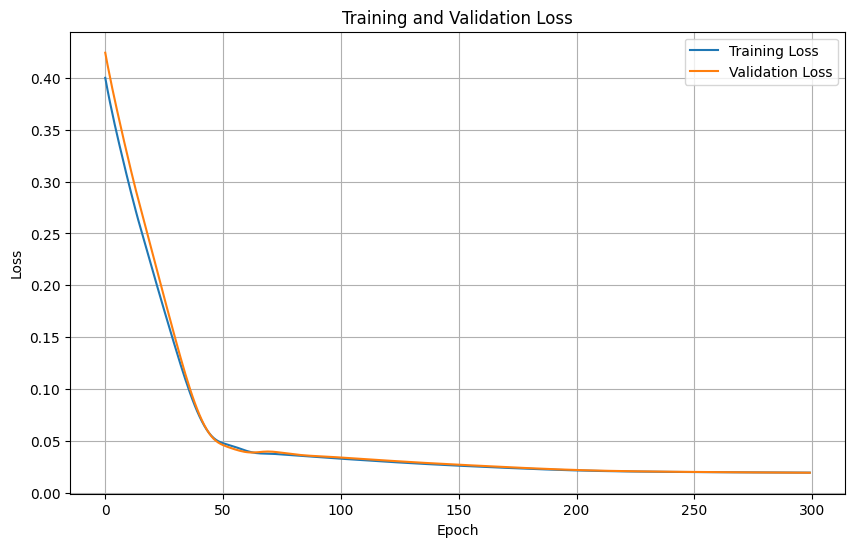

--------------------------------------------------------------------------------
❌ Missing test_loss
💡 Hint: Put the model in evaluation mode with model.eval()
❌ Missing r2_score
💡 Hint: Calculate R-squared score with utils.ml.r2_score(test_targets_original, test_predictions_original)
❌ Missing predictions_shape
❌ Missing values_match


In [16]:
# Exercise 5: Creating a Training Loop 🎯
# In this exercise, you will:
# 1. Create a training loop for your neural network
# 2. Implement forward and backward passes
# 3. Monitor training and validation loss

def train_model(model, 
                train_features, 
                train_targets, 
                val_features, 
                val_targets, 
                epochs=100):
    """
    Train a neural network model
    
    Args:
        model: PyTorch model to train
        train_features: Training features
        train_targets: Training targets
        val_features: Validation features
        val_targets: Validation targets
        epochs: Number of training epochs
        
    Returns:
        train_losses: List of training losses
        val_losses: List of validation losses
    """
    # Initialize lists to store losses
    train_losses = []
    val_losses = []
    
    # Put model in training mode
    model.train() # Your code here
    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Training"):
        # 1. Zero gradients
        model.optimizer.zero_grad() # Your code here
        
        # 2. Forward pass
        predictions = model(train_features) # Your code here
        
        # 3. Compute loss
        loss = model.loss_function(predictions, train_targets) # Your code here
        
        # 4. Backward pass
        loss.backward() # Your code here
        
        # 5. Update weights
        model.optimizer.step() # Your code here
        
        # 6. Store training loss
        train_losses.append(loss.item())
        
        # 7. Compute validation loss
        model.eval() # Set model to evaluation mode
        with torch.no_grad(): # No need to track gradients for validation
            val_predictions = model(val_features)
            val_loss = model.loss_function(val_predictions, val_targets).item()
            val_losses.append(val_loss)
        
        # Set model back to training mode
        model.train()
    
    return train_losses, val_losses

# Run training for 300 epochs
train_losses, val_losses = train_model(
    model=model,
    train_features=X_train_scaled,
    train_targets=y_train_scaled,
    val_features=X_val_scaled,
    val_targets=y_val_scaled,
    epochs=300
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Check your answer
answer = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'loss_trend': train_losses[0] > train_losses[-1],
    'overfit_check': val_losses[-1] <= val_losses[0] * 1.5  # Should not have increased much
}
checker.check_exercise(5, answer)

### Step 9: Fit Model
The next step is to fit the model using the training data. The model is trained for a specified number of epochs, and the training and validation loss is monitored during training. The number of epochs is a hyperparameter that determines how many times the model will be trained on the entire training dataset. Depending on the size of the dataset and the complexity of the model, the number of epochs can vary. A common practice is to start with a small number of epochs and increase it until the model starts to overfit the training data.

In [17]:
train_loss, val_loss = train(model_v1, 
                            X_train_tensor, 
                            y_train_tensor, 
                            X_val_tensor, 
                            y_val_tensor, 
                            epochs=3000)

Training ANNv1: 100%|██████████| 3000/3000 [00:14<00:00, 209.62it/s, train_loss=0.0596, val_loss=0.0774]


### Step 10: Evaluate Model
The next step is to evaluate the model using the validation and test data. The model is evaluated on the validation set during training to monitor its performance and prevent overfitting. 

Often we can plot the training and validation loss to see how well the model is performing. The training loss should decrease over time, while the validation loss should also decrease but may start to increase if the model starts to overfit the training data.

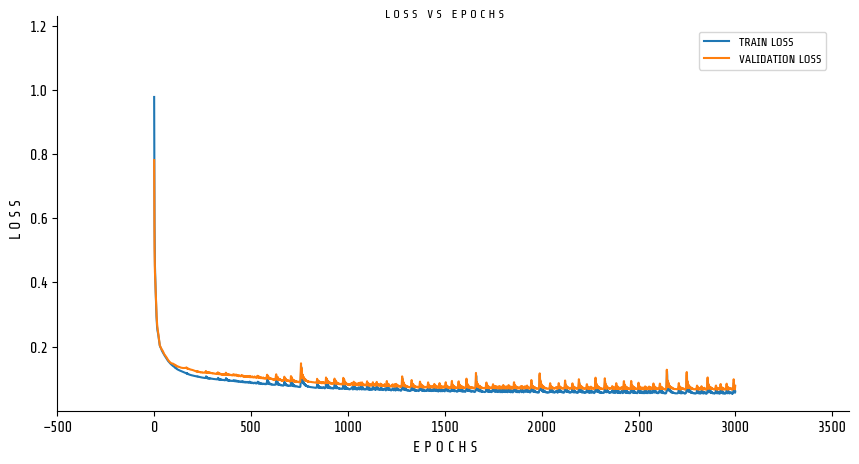

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_loss, label='Train Loss')
ax.plot(val_loss, label='Validation Loss')
utils.plotting.make_fig_pretty(ax, title='Loss vs Epochs', xlabel='Epochs', ylabel='Loss',ctab=True)
plt.show()

As we can see in the following figure, the training loss decreases over time, while the validation loss follows a similar trend. However, the validation loss starts to slowly deviate from the training loss after a certain number of epochs. This indicates that the model is starting to overfit the training data. The point at which the validation loss starts to increase is known as the "early stopping" point. This is the point at which we should stop training the model to prevent overfitting.

Since we are training a model with MSE loss, we can also plot the predicted output against the actual output to see how well the model is performing. The predicted output should be close to the actual output, and the points should be clustered around the diagonal line. If the points are scattered far from the diagonal line, it indicates that the model is not performing well.

We can also compute the R-squared value to quantify the performance of the model. The R-squared value is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The R-squared value ranges from 0 to 1, where 0 indicates that the model does not explain any of the variance in the data, and 1 indicates that the model explains all of the variance in the data.

For this step we are going to use the test set to evaluate the model. 

In [19]:
# Plot test vs prediction
y_test_pred = model_v1(X_test_tensor)
y_test_vals = y_test.values

# Inverse transform the predictions and targets to get the original scale
y_test_pred = y_scaler.inverse_transform(y_test_pred).detach().numpy()

joints = ['Shoulder Pitch',
          'Shoulder Roll',
          'Elbow Yaw',
          'Elbow Roll',
          'Wrist Yaw']
fig, ax = plt.subplots(figsize=(12, 14), nrows=5, ncols=1)

for ix in range(5):
    ax[ix].scatter(y_test_vals[:, ix], y_test_pred[:, ix], alpha=0.5)
    ax[ix].plot([y_test_vals[:, ix].min(), y_test_vals[:, ix].max()],
               [y_test_vals[:, ix].min(), y_test_vals[:, ix].max()], 'r--')
    ax[ix].set_xlim(y_test_vals[:, ix].min(), y_test_vals[:, ix].max())
    utils.plotting.make_fig_pretty(ax[ix], title=f'{joints[ix]}',
                         xlabel='Target', ylabel='Prediction')
plt.tight_layout()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
def evaluate(model: torch.nn.Module,
           features: torch.Tensor,
           targets: torch.Tensor):
    
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        y_pred = model(features)
        loss = model.criterion(y_pred, targets)

    return loss.item()

loss = evaluate(model_v1, X_test_tensor, y_test_tensor)

# Create predictions to compute the R2 score
model_v1.eval()
with torch.no_grad():
    y_pred = model_v1(X_test_tensor)
    y_pred = y_scaler.inverse_transform(y_pred)

y_test_eval = y_scaler.inverse_transform(y_test_tensor)
print(f"R2 Score: {utils.ml.r2_score(y_test_eval, y_pred)}")
print(f"Test Loss: {loss:.4f}")

R2 Score: 0.8802146911621094
Test Loss: 0.0756


Test Loss: 0.0173
R-squared Score: 0.7569


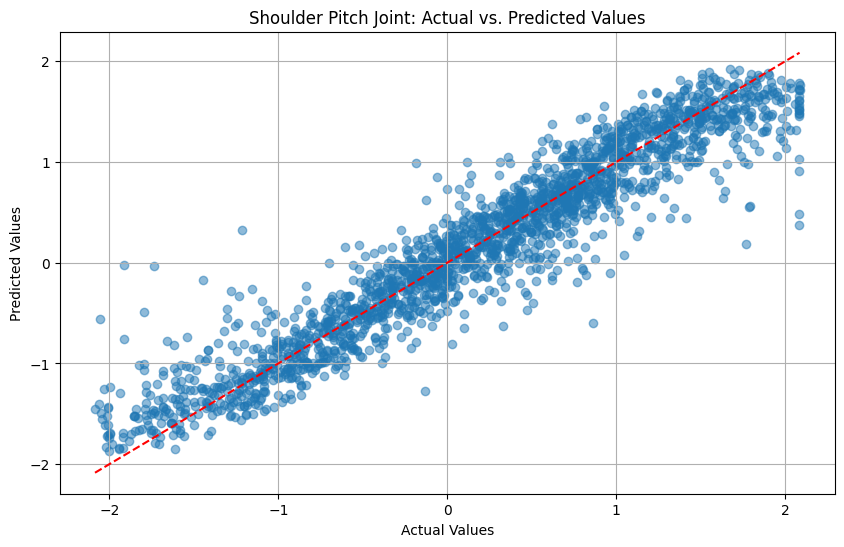

--------------------------------------------------------------------------------
✅ test_loss is correct!
✅ r2_score is correct!
✅ predictions_shape is correct!
✅ values_match is correct!

🎉 Excellent! All parts are correct!


In [ ]:
# Exercise 6: Model Evaluation 🎯
# In this exercise, you will:
# 1. Evaluate your trained model on the test set
# 2. Calculate R-squared score to measure model performance
# 3. Visualize actual vs. predicted values for one joint

# Put the model in evaluation mode
model.eval()

# Predict on the test set without computing gradients
with torch.no_grad():
    test_predictions = model(X_test_scaled) # Your code here
    
    # Calculate the test loss
    test_loss = model.loss_function(test_predictions, y_test_scaled) # Your code here
    
    # Convert predictions and targets back to original scale
    test_predictions_original = y_scaler.inverse_transform(test_predictions) # Your code here
    test_targets_original = y_scaler.inverse_transform(y_test_scaled) # Your code here

# Calculate the R-squared score
r2_score = utils.ml.r2_score(test_targets_original, test_predictions_original) # Your code here

# Print evaluation metrics
print(f"Test Loss: {test_loss.item():.4f}")
print(f"R-squared Score: {r2_score:.4f}")

# Visualize actual vs. predicted values for the shoulder pitch joint (first joint)
plt.figure(figsize=(10, 6))
plt.scatter(test_targets_original[:, 0].numpy(), test_predictions_original[:, 0].numpy(), alpha=0.5)
plt.plot([test_targets_original[:, 0].min(), test_targets_original[:, 0].max()], 
         [test_targets_original[:, 0].min(), test_targets_original[:, 0].max()], 'r--')
plt.title('Shoulder Pitch Joint: Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# ✅ Check your answer
answer = {
    'test_loss': test_loss.item(),
    'r2_score': r2_score,
    'predictions_shape': test_predictions_original.shape,
    'values_match': test_predictions_original.shape == test_targets_original.shape
}
checker.check_exercise(6, answer)

In [ ]:
# Exercise 7: Model Improvement 🎯
# In this exercise, you will:
# 1. Improve the model architecture by adding more layers
# 2. Experiment with different activation functions
# 3. Implement dropout for regularization

class ImprovedRobotArmNetwork(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout_rate: float = 0.2):
        """Initialize an improved neural network for robotic arm inverse kinematics
        
        Args:
            input_size: Number of input features
            hidden_size: Number of neurons in the hidden layer
            output_size: Number of output features
            dropout_rate: Dropout rate for regularization
        """
        # Initialize the parent class
        super().__init__() # Your code here
        
        # Define an improved network architecture with more layers and dropout
        self.fc1 = torch.nn.Linear(input_size, hidden_size) # Your code here
        self.bn1 = torch.nn.BatchNorm1d(hidden_size) # Your code here
        self.dropout1 = torch.nn.Dropout(dropout_rate) # Your code here
        self.activation = torch.nn.LeakyReLU(0.1) # Your code here
        
        # Hidden layers
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size) # Your code here
        self.bn2 = torch.nn.BatchNorm1d(hidden_size) # Your code here
        self.dropout2 = torch.nn.Dropout(dropout_rate) # Your code here
        
        # Output layer
        self.fc3 = torch.nn.Linear(hidden_size, output_size) # Your code here
        
    def forward(self, x):
        """Forward pass with improved architecture including batch normalization and dropout"""
        # First layer with batch normalization, activation, and dropout
        x = self.fc1(x) # Your code here
        x = self.bn1(x) # Your code here
        x = self.activation(x) # Your code here
        x = self.dropout1(x) # Your code here
        
        # Second layer with batch normalization, activation, and dropout
        x = self.fc2(x) # Your code here
        x = self.bn2(x) # Your code here
        x = self.activation(x) # Your code here
        x = self.dropout2(x) # Your code here
        
        # Output layer (no activation for regression task)
        x = self.fc3(x) # Your code here
        
        return x

# Initialize the improved model with appropriate dimensions
improved_model = ImprovedRobotArmNetwork(
    input_size=6, 
    hidden_size=128, 
    output_size=5, 
    dropout_rate=0.2
) # Your code here

# Create an Adam optimizer for the improved model with a learning rate of 0.001
optimizer = torch.optim.Adam(params=improved_model.parameters(), lr=0.001) # Your code here

# Create a Mean Squared Error loss function
loss_function = torch.nn.MSELoss() # Your code here

# Store the optimizer and loss function in the model for easy access
improved_model.optimizer = optimizer
improved_model.loss_function = loss_function

# Print the improved model architecture
print(improved_model)

# ✅ Check your answer
answer = {
    'improved_model': improved_model,
    'num_layers': 3,  # Count fully connected layers
    'has_dropout': hasattr(improved_model, 'dropout1'),
    'has_batch_norm': hasattr(improved_model, 'bn1'),
    'activation_type': type(improved_model.activation)
}
checker.check_exercise(7, answer)

ImprovedRobotArmNetwork(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (activation): LeakyReLU(negative_slope=0.1)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (loss_function): MSELoss()
)
--------------------------------------------------------------------------------
✅ improved_model is correct!
✅ num_layers is correct!
✅ has_dropout is correct!
✅ has_batch_norm is correct!
❌ Error checking activation_type: unsupported operand type(s) for -: 'type' and 'bool'
